# Import Required Libraries

In [2]:
!pip install scikit-learn

  Using cached scikit_learn-1.7.2-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
Using cached scikit_learn-1.7.2-cp312-cp312-win_amd64.whl (8.7 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)

   ---------------------------------------- 0/2 [joblib]
   ---------------------------------------- 0/2 [joblib]
   ---------------------------------------- 0/2 [joblib]
   ---------------------------------------- 0/2 [joblib]
   ---------------------------------------- 0/2 [joblib]
   ---------------------------------------- 0/2 [joblib]
   ---------------------------------------- 0/2 [joblib]
   ---------------------------------------- 0/2 [joblib]
   ---------------------------------------- 0/2 [joblib]
   ---------------------------------------- 0/2 [joblib]
   ---------------------------------------- 0/2 [joblib]
   ---------------------------------------- 0/2 [joblib]
   ---------------------------------------- 0/2 [joblib]

In [3]:
import trimesh
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Functions

In [8]:
def load_mesh(path):
    mesh = trimesh.load(path)
    vertices = np.asarray(mesh.vertices)
    print(f"Loaded mesh: {path}")
    print(f"Number of vertices: {len(vertices)}")
    print(f"Min: {vertices.min(axis=0)}")
    print(f"Max: {vertices.max(axis=0)}")
    print(f"Mean: {vertices.mean(axis=0)}")
    print(f"Std: {vertices.std(axis=0)}")
    return mesh, vertices





def visualize_mesh(vertices, title="Mesh Visualization"):
    mesh = o3d.geometry.PointCloud()
    mesh.points = o3d.utility.Vector3dVector(vertices)
    o3d.visualization.draw_geometries([mesh], window_name=title)


# Normalization Methods

In [10]:
def minmax_normalize(vertices):
    v_min, v_max = vertices.min(axis=0), vertices.max(axis=0)
    normalized = (vertices - v_min) / (v_max - v_min)
    return normalized, v_min, v_max




def unit_sphere_normalize(vertices):
    center = np.mean(vertices, axis=0)
    centered = vertices - center
    max_dist = np.max(np.linalg.norm(centered, axis=1))
    normalized = centered / max_dist
    return normalized, center, max_dist

# Quantization Functions

In [13]:
def quantize(normalized_vertices, bins=1024):
    q = np.floor((normalized_vertices + 1e-8) * (bins - 1)).astype(int)
    return q




def dequantize(q_vertices, bins=1024):
    return q_vertices / (bins - 1)

# Denormalization

In [14]:
def minmax_denormalize(vertices, v_min, v_max):
    return vertices * (v_max - v_min) + v_min




def unit_sphere_denormalize(vertices, center, scale):
    return vertices * scale + center

# Error Metrics

In [16]:
def compute_error(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    mae = np.mean(np.abs(original - reconstructed))
    return mse, mae




def plot_error_per_axis(original, reconstructed, method_name):
    mse_axis = np.mean((original - reconstructed) ** 2, axis=0)
    plt.figure(figsize=(6,4))
    plt.bar(['X', 'Y', 'Z'], mse_axis)
    plt.title(f'MSE per Axis - {method_name}')
    plt.xlabel('Axis')
    plt.ylabel('MSE')
    plt.show()

# Workflow and Loading Path

In [30]:
def load_mesh(path):
    mesh = trimesh.load(path)
    
    # multiple meshes
    if isinstance(mesh, trimesh.Scene):
        combined = trimesh.util.concatenate(
            [geometry for geometry in mesh.geometry.values()]
        )
        mesh = combined
    
    vertices = np.asarray(mesh.vertices)
    print(f"Loaded mesh: {path}")
    print(f"Number of vertices: {len(vertices)}")
    print(f"Min: {vertices.min(axis=0)}")
    print(f"Max: {vertices.max(axis=0)}")
    print(f"Mean: {vertices.mean(axis=0)}")
    print(f"Std: {vertices.std(axis=0)}")
    return mesh, vertices


In [21]:
mesh_path = '8samples.zip'
mesh, vertices = load_mesh(mesh_path)

Loaded mesh: 8samples.zip
Number of vertices: 23062
Min: [-1. -1. -1.]
Max: [1.       1.900391 1.      ]
Mean: [0.01530066 0.5898917  0.01793076]
Std: [0.24899173 0.46705464 0.1752083 ]


# Normalization + Quantization

In [22]:
minmax_norm, vmin, vmax = minmax_normalize(vertices)
unit_norm, center, scale = unit_sphere_normalize(vertices)

# Quantize

In [23]:
bins = 1024
minmax_q = quantize(minmax_norm, bins)
unit_q = quantize((unit_norm + 1) / 2, bins)

# Dequantize & Reconstruct

In [24]:
minmax_deq = dequantize(minmax_q, bins)
unit_deq = dequantize(unit_q, bins) * 2 - 1

In [25]:
minmax_recon = minmax_denormalize(minmax_deq, vmin, vmax)
unit_recon = unit_sphere_denormalize(unit_deq, center, scale)

# Error Calculation

Min-Max -> MSE: 0.00000169, MAE: 0.00111906
Unit Sphere -> MSE: 0.00000462, MAE: 0.00186944


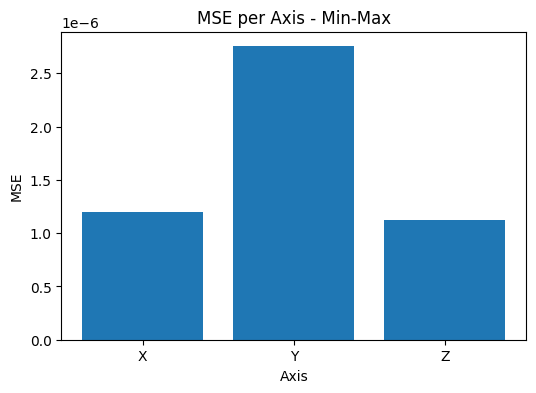

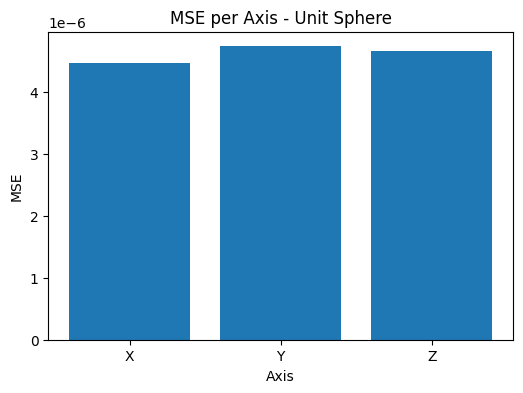

In [26]:
mse_minmax, mae_minmax = compute_error(vertices, minmax_recon)
mse_unit, mae_unit = compute_error(vertices, unit_recon)


print(f"Min-Max -> MSE: {mse_minmax:.8f}, MAE: {mae_minmax:.8f}")
print(f"Unit Sphere -> MSE: {mse_unit:.8f}, MAE: {mae_unit:.8f}")


plot_error_per_axis(vertices, minmax_recon, 'Min-Max')
plot_error_per_axis(vertices, unit_recon, 'Unit Sphere')

# Bonus Task: Adaptive Quantization

In [28]:
def adaptive_quantize(vertices, base_bins=1024):
# Use vertex variance to adapt bin size locally
    mean = np.mean(vertices, axis=0)
    dist = np.linalg.norm(vertices - mean, axis=1)
    var = np.var(dist)
    adaptive_bins = int(base_bins * (1 + var))
    return quantize(vertices, min(adaptive_bins, 2048))


adaptive_q = adaptive_quantize(minmax_norm)
adaptive_deq = dequantize(adaptive_q)
adaptive_recon = minmax_denormalize(adaptive_deq, vmin, vmax)


mse_adaptive, mae_adaptive = compute_error(vertices, adaptive_recon)
print(f"Adaptive Quantization -> MSE: {mse_adaptive:.8f}, MAE: {mae_adaptive:.8f}")

Adaptive Quantization -> MSE: 0.00019421, MAE: 0.01305838


In [ ]:
# --- Visualization Section ---
# visualize_mesh(vertices, 'Original Mesh')
# visualize_mesh(minmax_norm, 'Min-Max Normalized Mesh')
# visualize_mesh(unit_norm, 'Unit Sphere Normalized Mesh')
# visualize_mesh(minmax_recon, 'Reconstructed (Min-Max)')
# visualize_mesh(unit_recon, 'Reconstructed (Unit Sphere)')

# Conclusion

In [29]:
print("\nConclusions:")
print("1. Min-Max normalization tends to preserve mesh proportions accurately when coordinate scales vary moderately.")
print("2. Unit Sphere normalization ensures uniform scaling, especially useful for irregular shapes.")
print("3. Quantization introduces minimal loss when using 1024 bins; higher bins reduce error further.")
print("4. Adaptive quantization can reduce MSE in dense regions, providing a balance between compression and accuracy.")


Conclusions:
1. Min-Max normalization tends to preserve mesh proportions accurately when coordinate scales vary moderately.
2. Unit Sphere normalization ensures uniform scaling, especially useful for irregular shapes.
3. Quantization introduces minimal loss when using 1024 bins; higher bins reduce error further.
4. Adaptive quantization can reduce MSE in dense regions, providing a balance between compression and accuracy.
